In [1]:
import warnings
from fpdf import FPDF
warnings.filterwarnings("ignore")
import pandas as pd
from bs4 import BeautifulSoup
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random


def generate_report():
    print("Please Wait!")
    def text_to_pdf(text):
        text = str(text)
        return text.encode("latin-1", "replace").decode("latin-1")


    colors = ["#426d5c", "#ddd7cc", "#9c7159", "#326ab5", "#93c47d", "#bf9000"]


    def get_fundamentals(company_code):
        to_return = dict()
        html = f"https://www.screener.in/company/{company_code}/consolidated/"
        source = requests.get(html)
        soup = BeautifulSoup(source.text, "lxml")
        about_company = soup.find("div", class_ = "sub show-more-box about").p.text

        to_return.update({"Name" : soup.find("h1", class_ = "h2 shrink-text").text})
        to_return.update({"About": about_company})

        info = {
            "Metrix" : [],
            "Value" : []
        }

        flag = True
        skip = 0

        for span in soup.find("div", class_ = "company-ratios").find_all("span"):
            a = ((((str(span.text).replace("\n", "")).replace(" ", "")).replace("," , "")).replace("₹", ""))
            if skip == 0:
                if flag:
                    if a not in ["Editratios"]:
                        info["Metrix"].append(a)
                    flag = not flag

                    if a == "High/Low":
                        number_of_skips = 2
                    else:
                        number_of_skips = 1

                else:
                    info["Value"].append(a)
                    flag = not flag
                    skip = number_of_skips

            else:
                skip -= 1
        ratios = pd.DataFrame(info)
        to_return.update({"Important_Ratios" : ratios})
        tables = soup.find_all("table")
        quarterly_results = tables[0]
        def clean(bad_data):
            data = []
            for r in bad_data.find_all("tr"):
                row = []
                for value in r.find_all("th"):
                    row.append(value.text)
                for value in r.find_all("td"):
                    row.append(value.text)
                data.append(row)
            data = pd.DataFrame(data)
            for i in range(len(data.columns)):
                data.iloc[:,i] = data.iloc[:,i].str.replace(" ", "").str.replace("\n", "").str.replace(",", "").str.replace("%", "").str.replace("+", "")

            data.columns = data.iloc[0]

            data.set_index("", inplace = True)
            data.drop("", inplace = True)
            return data
        quarterly_results = clean(quarterly_results)

        quarterly_results.drop("RawPDF", inplace=True)
        to_return.update({"Quarterly Results" : quarterly_results})
        annual_results = clean(tables[1])
        to_return.update({"Annual Results" : annual_results})
        CSGR = tables[2] # S- Sales
        def clean2(data):
            dummy = {
                "Metrix" : [],
                "Value" : []
            }
            flag = True
            for i in data.find_all("td"):
                if flag:
                    dummy["Metrix"].append(i.text)
                    flag = not flag
                else:
                    dummy["Value"].append(i.text)
                    flag = not flag
            return pd.DataFrame(dummy)
        CSGR = clean2(CSGR)  # Compunded Sales Growth Rate
        to_return.update({"Sales Growth Rate" : CSGR})
        CPGR = clean2(tables[3])  # Compunded Profit Growth Rate
        to_return.update({"Profit Growth Rate" : CPGR})
        CSPGR= clean2(tables[4])  # Compunded Stock Price Groth Rate
        to_return.update({"Stock Price Grwoth Rate" : CSPGR})
        CROEGR = clean2(tables[5]) # Compunded ROE Growth Rate
        to_return.update({"ROE Growth Rate" : CROEGR})
        annual_bs = clean(tables[6])
        to_return.update({"Annual Balance Sheet" : annual_bs})
        annual_csf = clean(tables[7])
        to_return.update({"Annual CFS" : annual_csf})
        days = clean(tables[8])
        to_return.update({"Days" : days})
        shareholding = clean(tables[9])
        to_return.update({"Shareholdings" : shareholding})
        pros = soup.find("div", class_ = "pros").find_all("li")
        pros_copy  = []
        for i in pros:
            pros_copy.append(i.text)
        pros = pros_copy.copy()

        to_return.update({"Pros of Company" : pros})

        cons = soup.find("div", class_ = "cons").find_all("li")
        cons_copy  = []
        for i in cons:
            cons_copy.append(i.text)
        cons = cons_copy.copy()

        to_return.update({"Cons of Company" : cons})

        return to_return













    company_fundamentals = get_fundamentals(company_name)
    competitors_fundamentals = [get_fundamentals(comp) for comp in competitors_name]
    total_name = [company_name]
    total_name.extend(competitors_name)
    total_fundamentals = [company_fundamentals]
    total_fundamentals.extend(competitors_fundamentals)





    try:
        company_color =  random.sample(colors, len(total_name))
    except Exception as e:
        company_color = np.random.choice(colors, len(total_name))




    ratios_asitis = company_fundamentals["Important_Ratios"][company_fundamentals["Important_Ratios"]["Metrix"].isin(["MarketCap", "CurrentPrice", "StockP/E", "BookValue", "DividendYield", "ROCE", "ROE"])]





    for i, fundamentals in enumerate(total_fundamentals):
        temp = fundamentals["Important_Ratios"]
        temp.rename({"Value" : total_name[i]}, axis = 1, inplace=True)
        if i == 0:
            ratios_df = temp.copy()
        else:
            ratios_df = pd.merge(ratios_df, temp, how = 'outer', on = "Metrix")





    def clean_ratios_df(data):
        data = data.copy()
        for col in data.columns:
            data[col] = data[col].str.replace("Cr.", "").str.replace("%", "").str.replace(" ", "").str.replace("\xa0", "")
            values = []
            for value in data[col]:
                try:
                    v = float(value)
                except:
                    if col != "Metrix":
                        v = np.nan
                    else:
                        v = str(value)
                values.append(v)
            data[col] = values

        data.index = data["Metrix"]
        data = data.drop("Metrix", axis = 1)

        index_present = []
        index_to_drop = []
        required_ratios = ["CurrentPrice", "StockP/E", "BookValue" , "DividendYield", "ROCE", "ROE"]
        for index in data.index:
            if index in required_ratios:
                index_present.append(index)
            else:
                index_to_drop.append(index)

        index_not_present = set(required_ratios) - set(index_present)

        for index  in index_not_present:
            data.loc[index] = 0


        data = data.drop(index_to_drop)
        return data





    ratios_df = clean_ratios_df(ratios_df)





    all_metric = list(ratios_df.index)[0:6]
    plt.figure(figsize=(7, 7))
    for index, metric in enumerate(all_metric):
        plt.subplot(3, 2, index+1)
        sns.barplot(x = ratios_df.columns, y =  ratios_df.loc[metric], palette=company_color)
        for i,v in enumerate(total_name):
            plt.text(x= i, y = ratios_df.iloc[index, i] , s = ratios_df.iloc[index, i], ha = "center", rotation = 45 )
    plt.tight_layout()
    plt.savefig("QUICKGLANCE")





    def quart_perf(Data, typ):
        Data = Data.copy()
        flagger = {"sales" : 0, "opm" : 1, "np" : 2, "op" : 4}
        Data = pd.DataFrame(Data["Quarterly Results"].iloc[flagger[typ]])
        Data.index = pd.to_datetime(Data.index)
        Data.columns = [typ]
        Data['Date'] = Data.index
        for i, v in enumerate(Data[typ]):
            if v == np.nan or v == "":
                Data[typ][i] = np.nan
        Data[typ] = Data[typ].astype("float")
        return Data






    def clean_qResults(QuarterlyResults):
        Data = QuarterlyResults.copy()
        length = len(Data.columns)
        fresh_data = dict()
        all_index = Data.index.str.replace(" ", "").str.replace("\xa0", "")
        Data.index = all_index
        required_index = ["Sales","OPM", "NetProfit", "EPSinRs", "OperatingProfit", "Depreciation"]

        for req in required_index:
            if req in all_index:
                fresh_data.update({req: Data.loc[req]})
            else:
                fresh_data.update({req: [0 for _ in range((length))]})

        Data = pd.DataFrame(fresh_data.copy()).T

        Data = Data.reindex(required_index)

        return Data






    def clean_annualResults(AnnualResults):
        Data = AnnualResults.copy()
        length = len(Data.columns)
        fresh_data = dict()
        all_index = Data.index.str.replace(" ", "").str.replace("\xa0", "")
        Data.index = all_index
        required_index = ["Sales","OPM", "NetProfit", "EPSinRs", "DividendPayout", "OperatingProfit", "Depreciation"]

        for req in required_index:
            if req in all_index:
                fresh_data.update({req: Data.loc[req]})
            else:
                fresh_data.update({req: [0 for _ in range((length))]})

        Data = pd.DataFrame(fresh_data.copy()).T

        Data = Data.reindex(required_index)

        return Data





    def annual_perf(Data, typ):   
        flagger = {"sales" : 0, "opm" : 1, "np" : 2, "eps" : 3, "dpr" : 4, "op" : 5, "dep" : 6}
        Data = pd.DataFrame(Data["Annual Results"].iloc[flagger[typ]])
        Data.index = pd.to_datetime(Data.index)
        Data.columns = [typ]
        Data['Date'] = Data.index
        for i, v in enumerate(Data[typ]):
            if v == np.nan or v == "":
                Data[typ][i] = np.nan
        Data[typ] = Data[typ].astype("float")
        return Data




    plt.figure(figsize=(10  , 10))

    plt.suptitle("Quarterly Performance", fontsize = 20)

    title = {
        "Sales (Rs. Crores)" : "sales",
        "Operating Profit Margin" : "opm",
        "Net Profit (Rs. Crores)" : "np",
        "Operating Profit (Rs. Crores)" : "op"

    }

    for i in range(4): 
        plt.subplot(2, 2, i+1)
        ti = list(title.keys())[i]

        plt.title(ti)
        for i, competitor in enumerate(total_fundamentals): 
            competitor["Quarterly Results"] = clean_qResults(competitor["Quarterly Results"])
            sns.lineplot(data = quart_perf(competitor, title[ti]), x = "Date", y = title[ti], legend=True, color = company_color[i], marker = "o")
        plt.xticks(rotation = 45, ha = "right")
        plt.legend(total_name)
        plt.xlabel("")
        plt.ylabel("")
    plt.tight_layout()
    plt.savefig("QPERFORMANCE")


    plt.figure(figsize=(10  , 15))

    plt.suptitle("Annual Performance", fontsize = 20)

    title = {
        "Sales (Rs. Crores)" : "sales",
        "Operating Profit Margin" : "opm",
        "Net Profit" : "np",
        "Operating Profit" : "op",
        "Dividend Payout Ratio" : "dpr"

    }

    for i in range(5): 
        plt.subplot(3, 2, i+1)
        ti = list(title.keys())[i]
        plt.title(ti)
        for i, competitor in enumerate(total_fundamentals): 
            competitor["Annual Results"] = clean_annualResults(competitor["Annual Results"])
            sns.lineplot(data = annual_perf(competitor, title[ti]), x = "Date", y = title[ti], legend=True,color=company_color[i], marker="o")
            plt.ylabel("")
            plt.xlabel("")
        plt.xticks(rotation = 45, ha = "right")

        plt.legend(total_name)
    plt.tight_layout()
    plt.savefig("ANNUALPERFORMANCE")




    def correct_shareholding(data):
        data = data.copy()

        for col in data.columns:
            data[col] = data[col].astype("float")
        fresh_index  = []

        for ind in data.index:
            ind = ind.replace(" ", "").replace("\xa0", "")
            fresh_index.append(ind)
        data.index = fresh_index

        for index in ["Promoters", "FIIs", "DIIs", "Public", "Government"]:
            if index not in data.index:
                data.loc[index] = 0


        return data



    data = correct_shareholding(company_fundamentals["Shareholdings"])
    data = data.iloc[:, len(data.columns) - 1]
    try:
        c = random.sample(colors, len(data.keys())) 
    except Exception as e:
        c = np.random.choice(colors, len(data.keys()))

    plt.figure(figsize=(5, 5))
    plt.pie(x = data.values, labels= data.keys(), autopct="%1.1f%%", pctdistance=0.8, colors = c)
    plt.title("Shareholding Pattern")
    plt.savefig("SHAREHOLDINGPATTERN")


    qib_hold = dict()
    for i in range(len(total_name)):
        temp_data = correct_shareholding(total_fundamentals[i]["Shareholdings"])
        temp_data = temp_data.loc["FIIs"] + temp_data.loc['DIIs']
        qib_hold.update({total_name[i] : temp_data})
    qib_holding_data = pd.DataFrame(qib_hold)


    promoter_holding = dict()
    for i in range(len(total_name)):
        temp_data = correct_shareholding(total_fundamentals[i]["Shareholdings"])
        temp_data = temp_data.loc["Promoters"]
        promoter_holding.update({total_name[i] : temp_data})
    promoter_holding = pd.DataFrame(promoter_holding)


    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)

    for i, company in enumerate(qib_holding_data.columns):
        sns.lineplot(data = qib_holding_data, x = qib_holding_data.index, y = company, legend=True, color = company_color[i], marker = "o")
    plt.legend(qib_holding_data.columns)
    plt.xticks(rotation = 40, ha = "right")
    plt.title("QIB's Holding (FII + DII) %")
    plt.ylabel("")
    plt.xlabel("")


    plt.subplot(1, 2, 2)
    for i, company in enumerate(promoter_holding.columns):
        sns.lineplot(data = promoter_holding, x = promoter_holding.index, y = company, legend=True, color = company_color[i], marker = "o" )
    plt.legend(promoter_holding.columns)
    plt.xticks(rotation = 40, ha = "right")
    plt.title("Promoters Holding %")
    plt.ylabel("")
    # plt.savefig("PROMOTERHOLDING")

    plt.savefig("QIBPROMOTERHOLDING")


    def clean_cfs(cfs):


        cfs.index = cfs.index.str.replace(" ", "").str.replace("\xa0", "")
        cfs.columns = pd.to_datetime(cfs.columns)
        for i in cfs.index:
            for c in cfs.columns:
                try:
                    cfs.loc[i, c] = float(cfs.loc[i, c])
                except:
                    cfs.loc[i, c] = np.nan

        for cf in ['CashfromOperatingActivity', 'CashfromInvestingActivity', 'CashfromFinancingActivity']:
            if cf not in cfs.index:
                cfs.loc[cf] = np.nan
        return cfs


    def clean_bs(BalanceSheet):
        Data = BalanceSheet.copy()
        length = len(Data.columns)
        fresh_data = dict()
        all_index = Data.index.str.replace(" ", "").str.replace("\xa0", "")
        Data.index = all_index
        required_index = ["ShareCapital","Reserves", "Borrowings"]

        for req in required_index:
            if req in all_index:
                fresh_data.update({req: Data.loc[req]})
            else:
                fresh_data.update({req: [0 for _ in range(len(length))]})

        Data = pd.DataFrame(fresh_data.copy()).T

        Data = Data.reindex(required_index)

        return Data

    def annual_bw(Data, typ):
        Data = Data.copy()
        flagger = {"scap" : 0, "reserves" : 1, "borrowing" : 2}
        Data = pd.DataFrame(Data["Annual Balance Sheet"].iloc[flagger[typ]])
        Data.index = pd.to_datetime(Data.index)
        Data.columns = [typ]
        Data['Date'] = Data.index
        for i, v in enumerate(Data[typ]):
            if v == np.nan or v == "":
                Data[typ][i] = np.nan
        Data[typ] = Data[typ].astype("float")
        return Data

    roe = pd.DataFrame()
    roce = pd.DataFrame()


    for i, fundamental in enumerate(total_fundamentals):
        fund = fundamental.copy()
        fund['Annual Balance Sheet'] = clean_bs(fund['Annual Balance Sheet'])
        fund["Annual Results"] = clean_annualResults(fund["Annual Results"])
        if i == 0:
            roce = round((((annual_perf(fund, "op")["op"] - annual_perf(fund, "dep")["dep"] )/(annual_bw(fund, "borrowing")["borrowing"] + annual_bw(fund, "scap")["scap"] + annual_bw(fund, "reserves")["reserves"])) * 100), 2)
            roce = pd.DataFrame(roce, columns=[total_name[i]])
        else:
            roce[total_name[i]] = round((((annual_perf(fund, "op")["op"] - annual_perf(fund, "dep")["dep"] )/(annual_bw(fund, "borrowing")["borrowing"] + annual_bw(fund, "scap")["scap"] + annual_bw(fund, "reserves")["reserves"])) * 100), 2)


    for i, fundamental in enumerate(total_fundamentals):
        fund = fundamental.copy()
        fund['Annual Balance Sheet'] = clean_bs(fund['Annual Balance Sheet'])
        fund["Annual Results"] = clean_annualResults(fund["Annual Results"])
        if i == 0:
            roe = round(((annual_perf(fund, "np")["np"]/(annual_bw(fund, "scap")["scap"] + (annual_bw(fund, "reserves"))["reserves"])) * 100 ), 2)
            roe = pd.DataFrame(roe, columns=[total_name[i]])
        else:
            roe[total_name[i]] = round(((annual_perf(fund, "np")["np"]/(annual_bw(fund, "scap")["scap"] + (annual_bw(fund, "reserves"))["reserves"])) * 100 ), 2)


    for i, fundamental in enumerate(total_fundamentals):
        fund = fundamental.copy()
        fund["Annual Balance Sheet"] = clean_bs(fund["Annual Balance Sheet"])
        fund["Annual Results"] = clean_annualResults(fund["Annual Results"])
        if i == 0:
            borrowing = (annual_bw(fund, "borrowing")["borrowing"])
            scap = (annual_bw(fund, "scap")["scap"])
            reserves = (annual_bw(fund, "reserves")["reserves"])
            debt_equity = borrowing/(scap + reserves)
            debt_equity = pd.DataFrame(debt_equity)
            debt_equity.columns = [total_name[i]]
        else:
            borrowing = (annual_bw(fund, "borrowing")["borrowing"])
            scap = (annual_bw(fund, "scap")["scap"])
            reserves = (annual_bw(fund, "reserves")["reserves"])
            temp = borrowing/(scap + reserves)

            debt_equity[total_name[i]] = temp

    plt.figure(figsize=(10  , 15))
    
    plt.suptitle("Financial Performance Indicators", fontsize = 20 )

    plt.subplot(3,2,1)

    cfs = clean_cfs(company_fundamentals["Annual CFS"])
    sns.lineplot(x = cfs.columns, y = cfs.loc["CashfromOperatingActivity", :], legend=True, color = colors[1], marker = "o")
    sns.lineplot(x = cfs.columns, y = cfs.loc["CashfromInvestingActivity", :], legend=True, color = colors[3], marker = "o")
    sns.lineplot(x = cfs.columns, y = cfs.loc["CashfromFinancingActivity", :], legend=True, color = colors[4], marker = "o")
    plt.title("Cash Flow Analysis")
    plt.xlabel("")
    plt.ylabel("")
    plt.legend(["CFOA", "CFIA", "CFFA"])
    # plt.savefig("CFS")


    plt.subplot(3,2,2)


    first_time = True
    for i, company in enumerate(total_fundamentals):
        company_fundamentals_copy = company.copy()
        company_fundamentals_copy["Annual Results"] = clean_annualResults(company_fundamentals_copy['Annual Results'])
        netprofit = annual_perf(company_fundamentals_copy, "np")
        cfoa = pd.DataFrame(clean_cfs(company_fundamentals_copy['Annual CFS']).loc["CashfromOperatingActivity"])
        cfoa['Date'] = cfoa.index
        cfoa_np = pd.merge(cfoa, netprofit, on = "Date", how = "inner")

        cfoa_by_np = []
        for index in cfoa_np.index:
            net_p = cfoa_np.loc[index, "np"]
            cfoa_ = cfoa_np.loc[index, "CashfromOperatingActivity"]
            if (net_p > 0) and (cfoa_ >= 0):
                cfoa_by_np.append(cfoa_ / net_p)
            else:
                cfoa_by_np.append(np.nan)

        cfoa_np["cfoa/np"] = cfoa_by_np
        sns.lineplot(data = cfoa_np, x = "Date", y = "cfoa/np", legend=True, color = company_color[i], marker = "o")

        
    plt.title("CFOA by PAT*")
    plt.legend(total_name)
    plt.xlabel("")
    plt.ylabel("")
    # plt.savefig("CFOBYPAT")





    plt.subplot(3,2,3)

    for i, col in enumerate(roce.columns):
        sns.lineplot(data = roce, x = roce.index, y = col, legend=True, color = company_color[i], marker = "o" )
    plt.title("ROCE % Across Years \n(EBIT/Capital, Reserves and Borrowings)")
    plt.xlabel("")
    plt.ylabel("")
    plt.legend(total_name)
    # plt.savefig("ROCE")


    plt.subplot(3,2,4)


    for i, col in enumerate(roe.columns):
        sns.lineplot(data = roe, x = roe.index, y = col, legend=True, color = company_color[i], marker = "o")
    plt.title("ROE % Across Years \n(Net Profit/Capital and Reserves)")
    plt.xlabel("")
    plt.ylabel("")
    plt.legend(total_name)
    # plt.savefig("ROE")


    plt.subplot(3,2,5)

    sns.lineplot(data = roe, x = roe.index, y = company_name, legend=True, color = colors[0], marker = "o")
    sns.lineplot(data = roce,x = roce.index, y = company_name, legend=True,  color = colors[1], marker= "o" )
    plt.title("ROE vs ROCE Comparison")
    plt.xlabel("")
    plt.ylabel("")
    plt.legend(["ROE", "ROCE"])
    # plt.savefig("ROEROCE")


    plt.subplot(3,2,6)

    for i, col in enumerate(debt_equity.columns):
        sns.lineplot(data = debt_equity, x = debt_equity.index, y = col, legend=True, color = company_color[i], marker = "o")
    plt.title("Debt by Equity Ratio across years")
    plt.xlabel("")
    plt.ylabel("")
    plt.legend(total_name)

    plt.tight_layout()

    plt.savefig("LASTANALYSIS")
    
    def clean_days(days):
        data = days.copy()
        all_index = data.index.str.replace(" ", "").str.replace("\xa0", "")
        data.index = all_index

        data.columns = pd.to_datetime(data.columns)

        for index in data.index:
            for col in data.columns:

                try:
                    v = float(data.loc[index, col])
                except:
                    v = np.nan


                data.loc[index, col] = v


        for c in ['DebtorDays', 'InventoryDays', 'DaysPayable', "CashConversionCycle", "WorkingCapitalDays"]:
            if c not in data.index:
                data.loc[c] = np.nan


        return data.loc[['DebtorDays', 'InventoryDays', 'DaysPayable', "CashConversionCycle", "WorkingCapitalDays"]]
    

    plt.figure(figsize=(10, 15))
    for i in range(len(total_name)):
        total_fundamentals[i]["Days"] = clean_days(total_fundamentals[i]["Days"])

    plt.suptitle("Working Capital Metrics", fontsize = 20 )

    for x in range(5):

        plt.subplot(3, 2, x+ 1)

        for i, tf in enumerate(total_fundamentals):
            data = tf["Days"]
            sns.lineplot(x = data.columns, y = data.loc[data.index[x]], legend=True, color = company_color[i], marker = "o")
        plt.legend(total_name)
    plt.tight_layout()    

    plt.savefig('WORKINGCAPITAL')

    

    class PDF(FPDF):
        def header(self):
            # by default header function postions the cell in top 20 mm margin
            self.set_font("Times", "B", 10)
            self.cell(w = 0, h = 10, txt = text_to_pdf(f"{company_fundamentals['Name']}"), border=0, ln = 1, align = 'L')
        def footer(self):

            self.set_xy(x = 210 - 55, y = 297 -20 + 6) # y -> we brought the position in lower 20 mm margin and add hight 5 for 10 mm height of footer
            a = "connect.jpg"
            b = "linkedin.png"
            self.image(b, h= 7, w = 7, link="https://www.linkedin.com/in/abhay-gupta-b72807161/")
            self.set_font("Times", "B", 10)
            self.set_xy(x = 210 - 40, y = 297 -20 + 5)
            self.cell(w = 0, h = 5, txt = text_to_pdf("abhay-gupta-b72807161"), border=0, ln = 1, align = 'R', link="https://www.linkedin.com/in/abhay-gupta-b72807161/")
            self.cell(w = 0, h = 5, txt = text_to_pdf("Click Here"), border=0, ln = 1, align = 'R', link="https://www.linkedin.com/in/abhay-gupta-b72807161/")

    pdf = PDF()
    pdf.add_page()

    pdf.set_author("Abhay Gupta")
    pdf.set_font("Times", "B", 30)
    pdf.cell(h = 30, w = 0, txt = text_to_pdf(f"{company_fundamentals['Name']}"), align="C", ln = 1)
    pdf.set_font("Times", "", 12)
    pdf.multi_cell(w = 0, h = 5, txt = text_to_pdf(company_fundamentals['About']), align = "J")


    y_before_ratios = pdf.get_y()
    width = 27
    height= 10
    x = 210/2 - 3.5*width
    y = pdf.get_y() + 5
    for i in range(len(ratios_asitis)):
        metrix = ratios_asitis.iloc[i, 0]
        value = ratios_asitis.iloc[i, 1]
        pdf.set_xy(x = x, y= y)
        pdf.set_font("Times", "BU", 12)
        pdf.cell(txt=text_to_pdf(metrix), h = height , w = width, border=0, align="C")
        pdf.set_xy(x = x, y= y + height)
        pdf.set_font("Times", "", 12)
        pdf.cell(txt=text_to_pdf(value), h = height , w = width, border=0, align="C")
        x = x + width
    pdf.set_y(y_before_ratios + 30)

    pdf.image("QUICKGLANCE.PNG", w= 190, h = 254 - pdf.get_y())

    pdf.add_page()


    pdf.image("QPERFORMANCE.PNG", w = 190, h = 190)

    pdf.add_page()
    pdf.image("ANNUALPERFORMANCE.PNG", w = 190, h = 250)
    pdf.add_page()
    pdf.image("SHAREHOLDINGPATTERN.png", w = 190, h = 128)
    pdf.set_x(0)
    pdf.image("QIBPROMOTERHOLDING.png", w= 220, h= 100)
    pdf.add_page()
    pdf.image("LASTANALYSIS.png", w= 190, h= 250)
    pdf.add_page()
    pdf.image("WORKINGCAPITAL.png", w= 190, h= 250)
    pdf.output("Report.pdf", 'F')

In [2]:
company_name = "TTML"
competitors_name = ["BHARTIARTL", "TATACOMM"]

Please Wait!


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


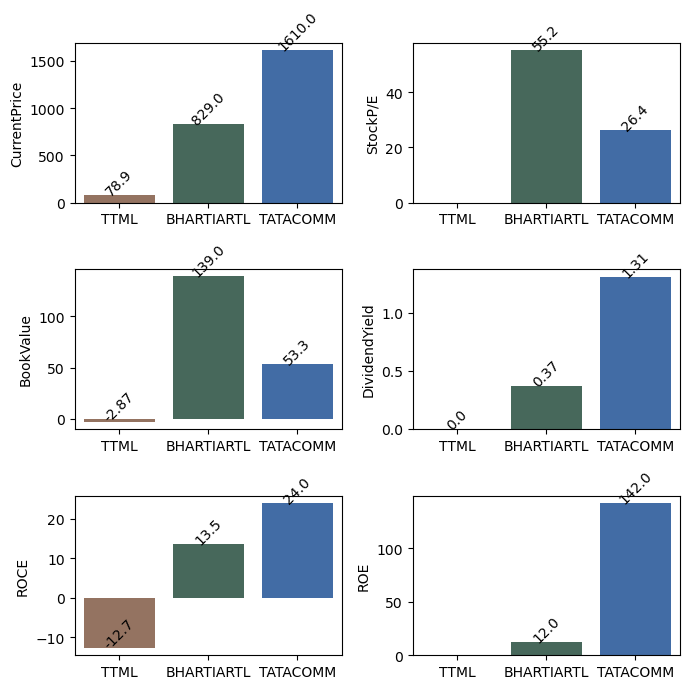

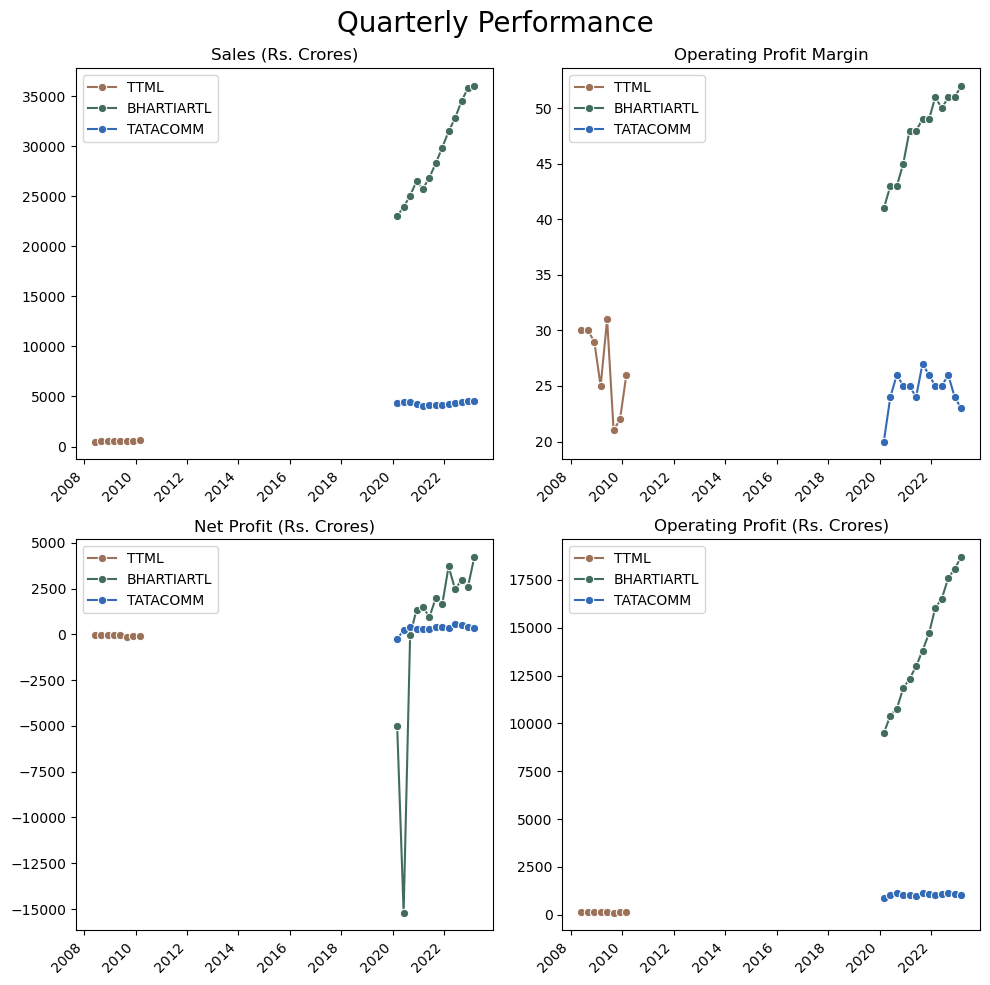

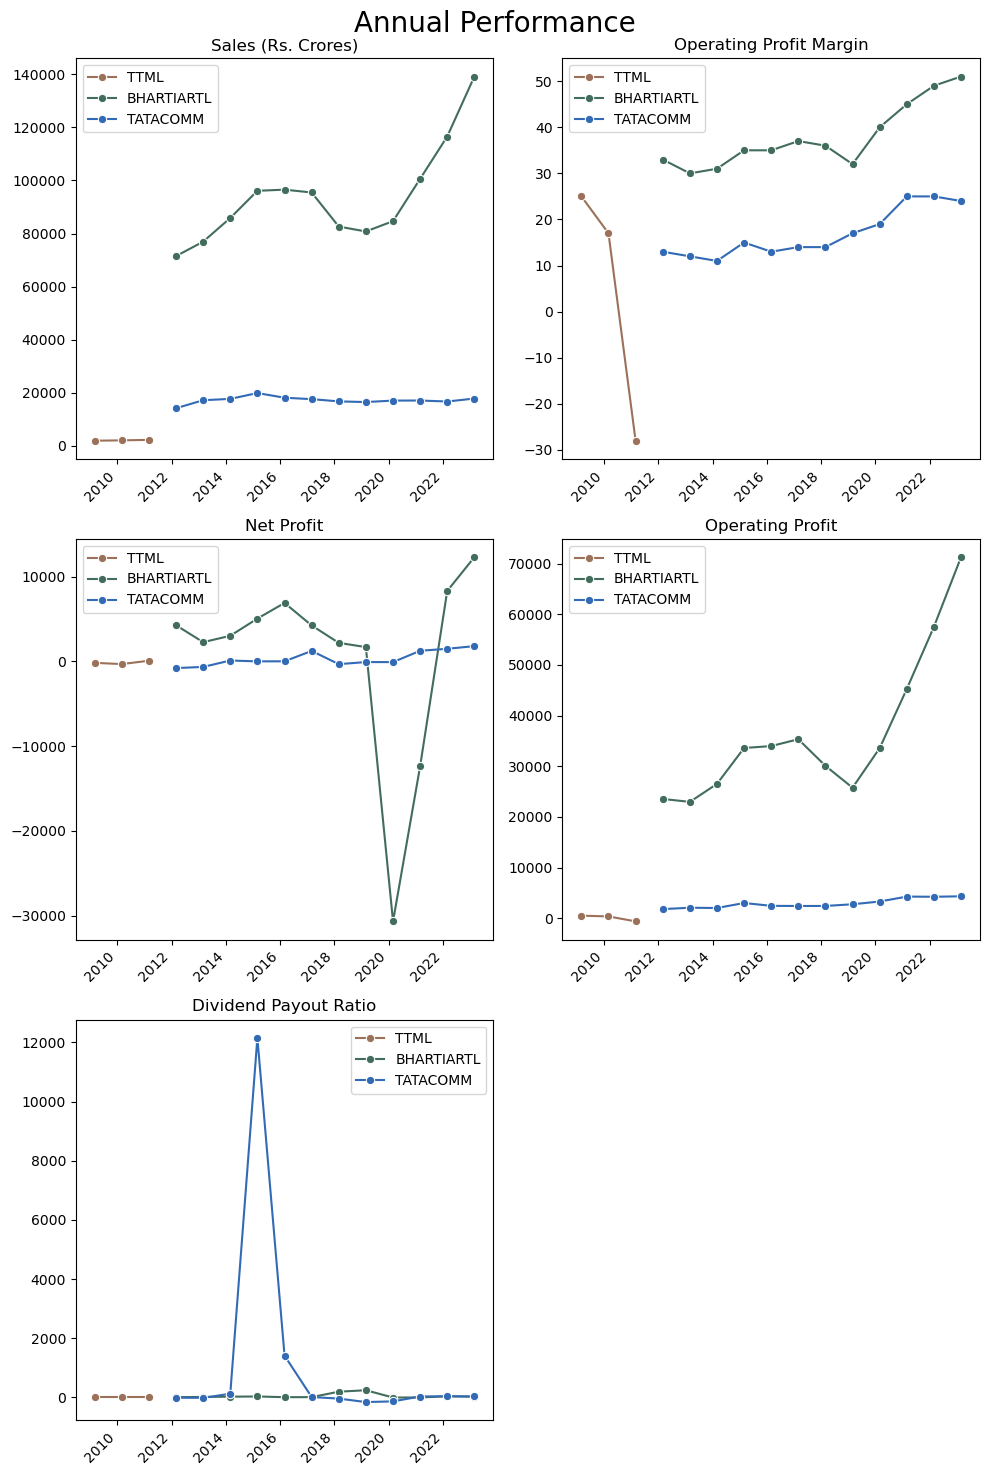

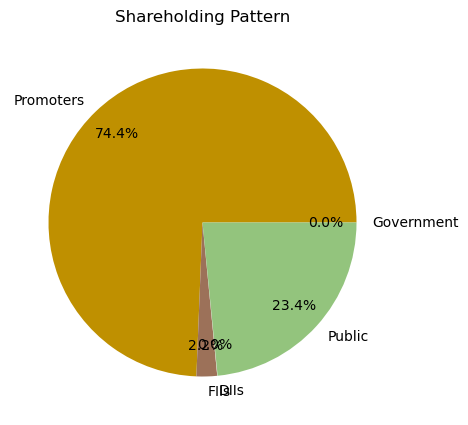

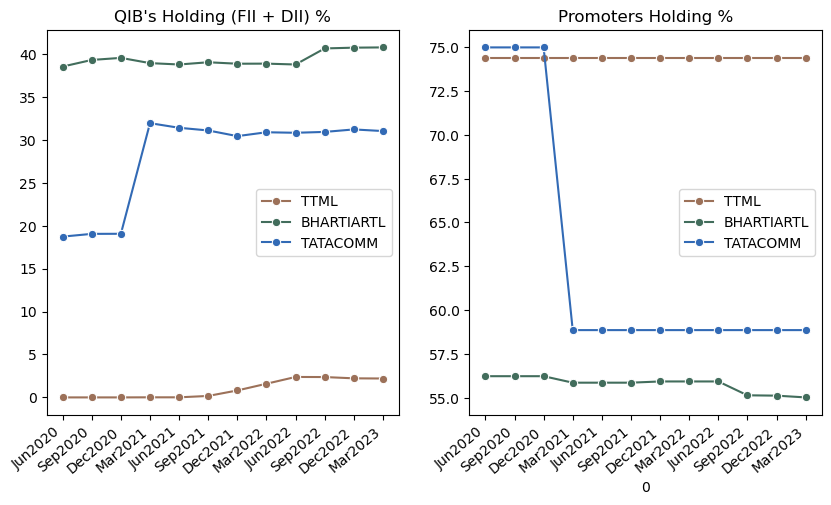

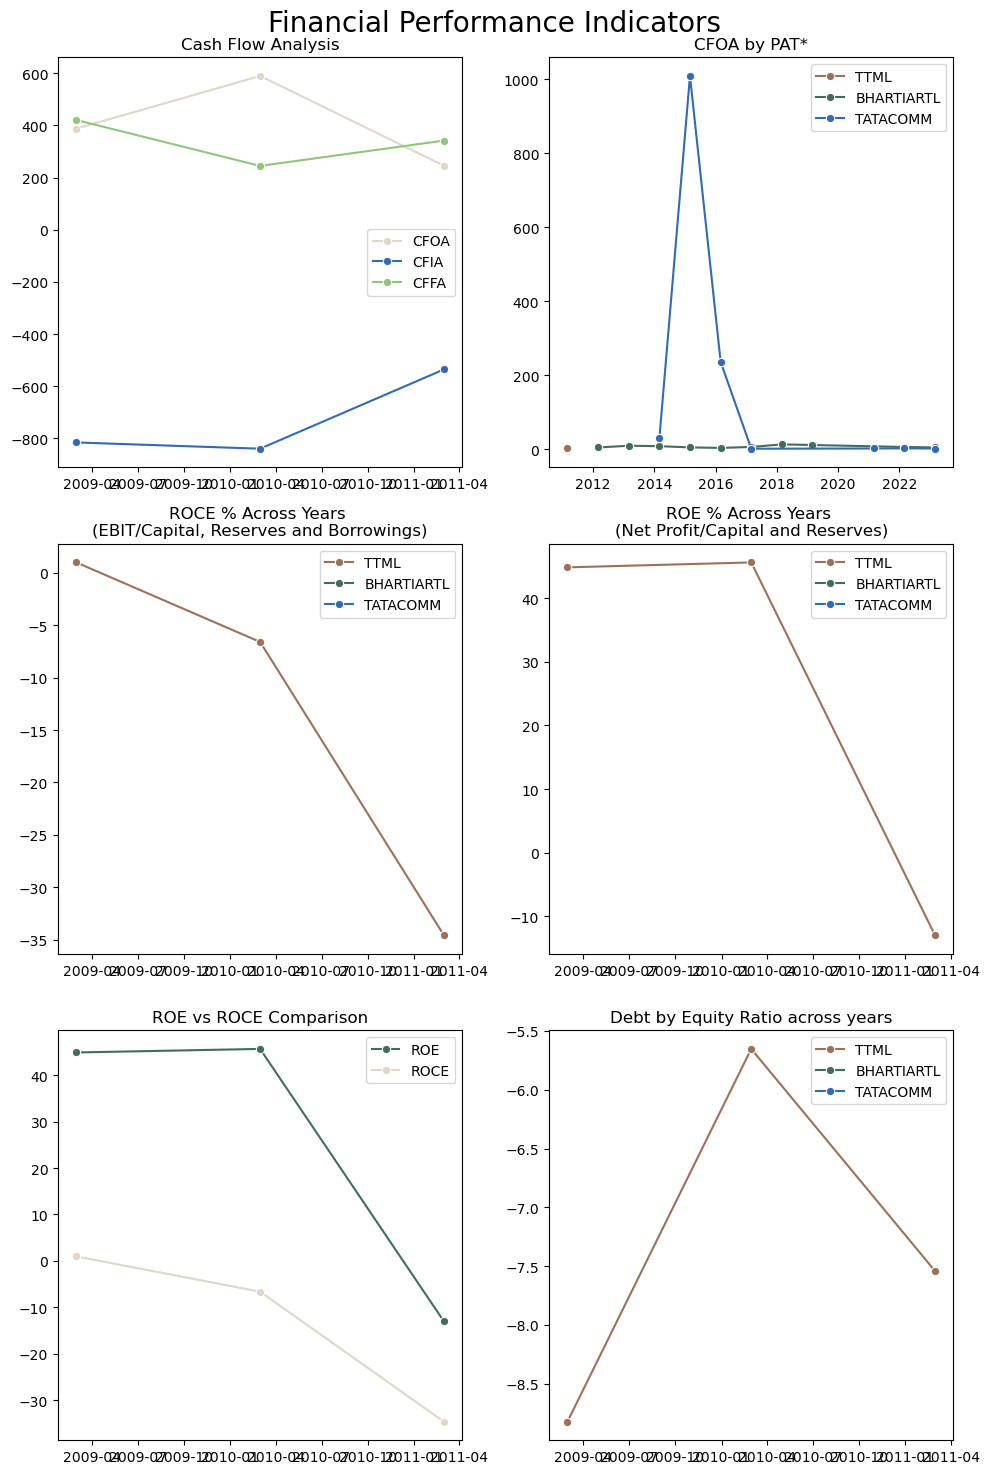

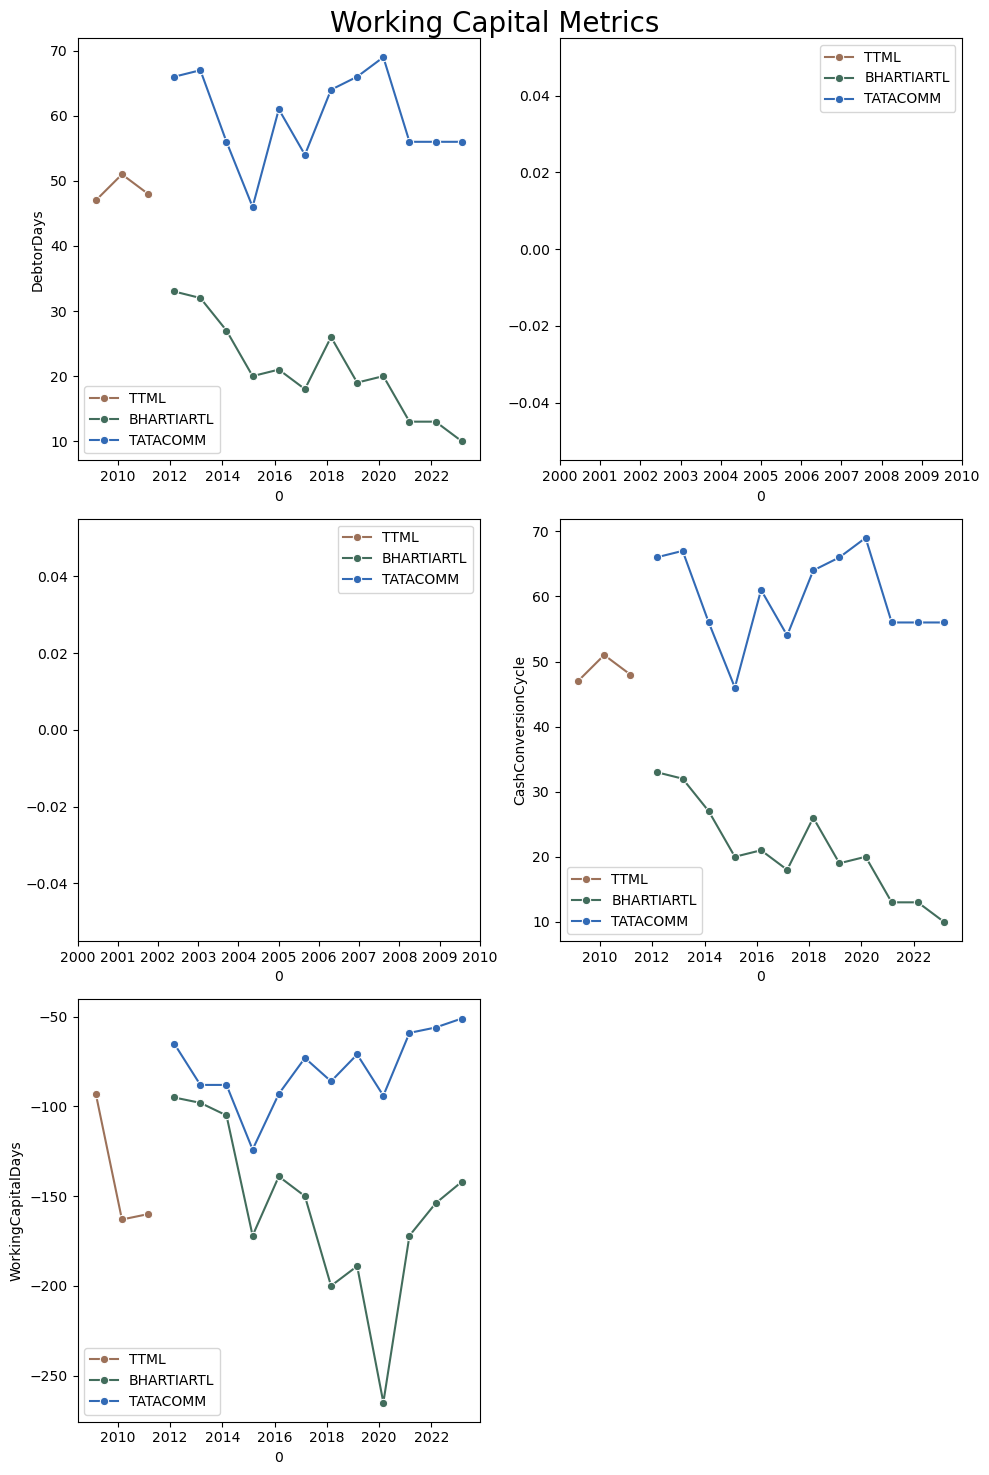

In [3]:
generate_report()